In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from fastai.text.all import *

path = "/content/drive/My Drive/Praj"

In [3]:
# create TextLMDataBunch using the csv in path, (TextClasDataBunch is a part of fastai V1 which is now no longer supported so I am using TextDataLoaders as its part of fastai V2.)
#     remember to specify the text column
data_lm = TextDataLoaders.from_csv(path, 'train.csv', text_col='review', is_lm=True, bs=64)

In [5]:
# create TextClasDataBunch using the csv in path, (TextClasDataBunch is a part of fastai V1 which is now no longer supported so I am using TextDataLoaders as its part of fastai V2.)
#     remember to specify the text/label column
#     specify test dataset, vocab, and bs
data_clas = TextDataLoaders.from_csv(path, 'train.csv', text_col='review', label_col='sentiment', valid='test.csv', text_vocab=data_lm.vocab, bs=32)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [7]:
# create language model learner with AWD_LSTM architecture and drop_mult of 0.5
lm_learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, metrics=[Perplexity()])

SuggestedLRs(valley=0.007585775572806597)

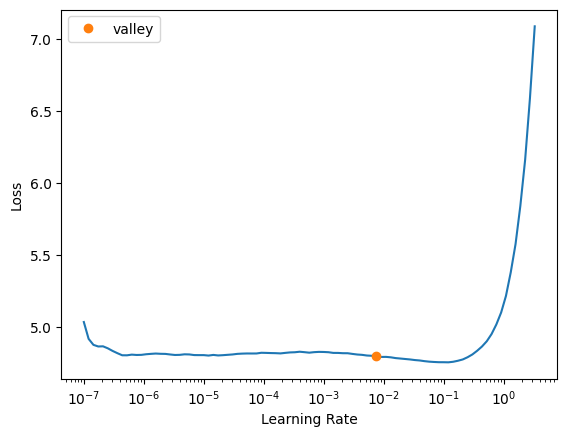

In [8]:
# find a learing rate
lm_learner.lr_find()

In [10]:
# fit one cycle
lm_learner.fit_one_cycle(5, 0.007585775572806597)


epoch,train_loss,valid_loss,perplexity,time
0,4.262588,4.125887,61.922733,08:56
1,4.192450,4.068754,58.484028,09:06
2,4.057375,4.026298,56.052994,09:08
3,3.952043,3.996868,54.427399,09:10
4,3.858528,3.991861,54.155598,09:06


In [11]:
# save the encoder
lm_learner.show_results()
lm_learner.save_encoder('model')

,input,target,pred
0,"xxbos xxmaj ok the film was n't going to win any awards and it is pure bubblegum , and it is a modern update on "" it 's a wonderful life "" . xxmaj but it 's just come out as a cheap release on xxup dvd and there are a lot worse ways of blowing $ 13 . xxmaj you get a film that has a surprisingly strong cast but for","xxmaj ok the film was n't going to win any awards and it is pure bubblegum , and it is a modern update on "" it 's a wonderful life "" . xxmaj but it 's just come out as a cheap release on xxup dvd and there are a lot worse ways of blowing $ 13 . xxmaj you get a film that has a surprisingly strong cast but for most","xxmaj the , first is n't a to be the awards , i was a crap - but it is a great movie of the the 's a xxmaj movie . . xxmaj it it 's not a on of a movie , . a dvd . i is some few of than to making it xxunk million xxmaj it 'll a lot that is a lot good cast and it the"
1,"disguised as a man in the day . xxmaj by night cybersix patrols the xxunk guy by the name of xxmaj von xxunk is the one who created cybersix , and once he finds put she is alive he uses everything he can to capture her.if u have never watched it before u should totally download it . xxmaj it was the best xxup tv show in the world . xxmaj why","as a man in the day . xxmaj by night cybersix patrols the xxunk guy by the name of xxmaj von xxunk is the one who created cybersix , and once he finds put she is alive he uses everything he can to capture her.if u have never watched it before u should totally download it . xxmaj it was the best xxup tv show in the world . xxmaj why did","as a xxmaj 's a xxmaj , xxmaj the the , , were xxmaj , was the xxmaj of xxmaj xxunk xxmaj , a most who is the . and the again was himself his is in and is his to has to make the you xxrep a seen it . . xxrep have xxunk it . xxmaj the is a first of dvd movie ever the world . xxmaj it did"
2,"stylish gift shop in xxmaj budapest , and the various human relationships that make the store such a close - knit family . xxmaj when store - owner xxmaj hugo xxmaj matuschek ( frank xxmaj morgan ) begins to suspect his oldest employee of having an affair with his wife , we witness the breakdown of two families , both at home and at work . xxmaj there 's absolutely no reason","gift shop in xxmaj budapest , and the various human relationships that make the store such a close - knit family . xxmaj when store - owner xxmaj hugo xxmaj matuschek ( frank xxmaj morgan ) begins to suspect his oldest employee of having an affair with his wife , we witness the breakdown of two families , both at home and at work . xxmaj there 's absolutely no reason why","and , , the xxunk . and a xxmaj xxmaj - in are up film a a xxunk - knit community . xxmaj the the owner owner xxmaj xxunk xxmaj matuschek ( as xxmaj morgan ) and to take that wife son , the a affair with xxmaj wife , he get a xxmaj of his of , the of the and in home . xxmaj the is no no reason to"
3,"xxmaj treasury . xxmaj although xxmaj free xxmaj money has some moments of humor , for most of the time it 's quite beneath the talents of all those involved . xxmaj some of them would include xxmaj donald xxmaj sutherland as an equally corrupt judge and xxmaj mira xxmaj sorvino as his xxunk , but also straight arrow xxup fbi xxunk course these people and the rest of the cast got","treasury . xxmaj although xxmaj free xxmaj money has some moments of humor , for most of the time it 's quite beneath the talents of all those involved . xxmaj some of them would include xxmaj donald xxmaj sutherland as an equally corrupt judge and xxmaj mira xxmaj sorvino as his xxunk , but also straight arrow xxup fbi xxunk course these people and the rest of the cast got to","xxunk xxmaj xxmaj the the treasury xxmaj willy is been of of interest , it example of the time , is a funny the surface of xxmaj the involved . xxmaj the of the are have xxmaj xxunk xxmaj sutherland , the xxmaj good agent , xxmaj donald xxmaj sorvino as a xxunk . b

In [12]:
lm_learner.predict("this movie talks about Canadian", n_words=20)

"this movie talks about Canadian boy Ben Wolf . However , older boy men like him had everyone n't mentioned ."

In [17]:
lm_learner.predict("I am from India", n_words=25)

'i am from India publicized for this piece of Profiled male for readings it changed . i felt obligated to pay for this programme hundreds of times i'

In [18]:
clas_learner = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, metrics=accuracy)
clas_learner.load_encoder('model')

SuggestedLRs(valley=0.005248074419796467)

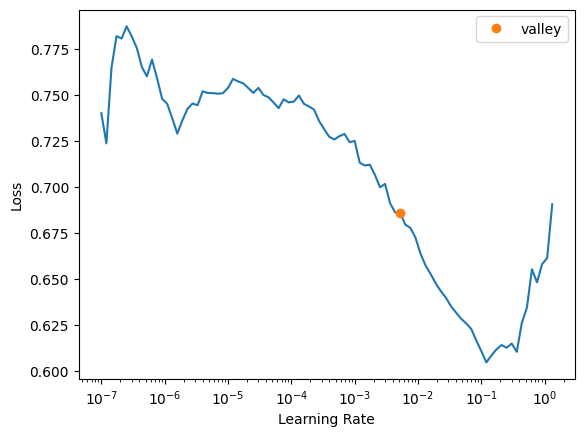

In [19]:
clas_learner.lr_find()

In [20]:
# tune the text_classifier_learner to accpetable accuracy (>80%)
clas_learner.fine_tune(5, base_lr=0.005248074419796467, freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,time
0,0.394978,0.351755,0.844000,02:12


epoch,train_loss,valid_loss,accuracy,time
0,0.309895,0.256712,0.893600,05:23
1,0.247149,0.237186,0.901400,05:25
2,0.196784,0.214003,0.918400,05:25
3,0.170048,0.206552,0.922600,05:24
4,0.141370,0.217764,0.923400,05:25


In [21]:
clas_learner.show_results()

,text,category,category_
0,"xxbos xxmaj some have praised xxunk xxmaj lost xxmaj xxunk as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults.this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older adventure movies has been done well before , ( think xxmaj the xxmaj dirty xxmaj dozen ) but -atlantis- represents one of the worse films in that motif . xxmaj the characters are weak . xxmaj even the background that each member trots out seems stock and awkward at best . xxmaj an xxup md / xxmaj medicine xxmaj man , a tomboy mechanic whose father always wanted sons , if we have not at least seen these before , we have seen mix",negative,negative
1,"xxbos xxmaj chris xxmaj rock deserves better than he gives himself in "" down xxmaj to xxmaj earth . "" xxmaj as directed by brothers xxmaj chris & xxmaj paul xxmaj weitz of "" american xxmaj pie "" fame , this uninspired remake of xxmaj warren xxmaj beatty 's 1978 fantasy "" heaven xxmaj can xxmaj wait , "" itself a rehash of 1941 's "" here xxmaj comes xxmaj mr . xxmaj jordan , "" lacks the xxunk profane humor that won xxmaj chris xxmaj rock an xxmaj emmy for his first xxup hbo special . xxmaj predictably , he spouts swear words from a to xxup z , but he consciously avoids the xxmaj f - word . xxmaj anybody who saw this gifted african - american comic in "" lethal xxmaj weapon 4 , "" "" dogma , "" or "" nurse xxmaj betty "" knows he",negative,negative
2,"xxbos xxmaj it is not as great a film as many people believe ( including my late aunt , who said it was her favorite movie ) . xxmaj but due to the better sections of this film noir , particularly that justifiably famous "" fun house "" finale , xxup the xxup lady xxup from xxup shanghai has gained a position of importance beyond it 's actual worth as a key to the saga of xxmaj orson xxmaj welles ' failure to conquer xxunk 1946 xxmaj welles ' position as a xxmaj hollywood figure was mixed . xxup citizen xxup kane was not recognized as the great movie it has since been seen as due to the way it was attacked by the xxmaj hearst press and by xxmaj hollywood insiders themselves . xxmaj welles ' attempt at total control ( direction and production and acting ) of his",positive,positive
3,"xxbos xxmaj the xxmaj war xxmaj between the xxmaj states was perhaps the darkest hour in the history of xxmaj america ; a war that pitted brother against brother and family against family and left scars that even today have not yet healed , and in all probability never will . xxmaj and , as in any story about any war , beyond any historical significance it is the personal discord behind the greater conflict that creates the emotional impetus that makes it involving . xxmaj it is the human element that renders the context necessary to give it perspective , which is what director xxmaj ang xxmaj lee provides in ` ride xxmaj with the xxmaj devil , ' a xxmaj civil xxmaj war drama in which he focuses on the personal travails within the broader depiction of the xxmaj war itself , and along the way manages to",positive,positive
4,"xxbos xxmaj while the original 1932 version , with xxmaj preston xxmaj foster , was good , there 's no remake more worthy than this 1959 one , or more impossible to find anywhere , just as i strongly suspect xxmaj mickey xxmaj rooney to have had something to do with that . xxmaj never could a mere performance have ever been so masterfully brilliant , or a script more thought - provoking , as well as an improvement upon the original . xxmaj many years after the last of my several viewings of this film , in 1970 , i read an article in which xxmaj mickey xxmaj rooney was recounting a visit he 'd made to death row , and which had apparently very drastically eliminated whatever sense of personal identification he 'd felt with people in similar circumstances . xxmaj the article was a

In [22]:
clas_learner.predict("This is a horrible movie.")

('negative', tensor(0), tensor([9.9959e-01, 4.1183e-04]))

In [23]:
clas_learner.predict("This is a great movie,")

('positive', tensor(1), tensor([0.0018, 0.9982]))

In [24]:
# Check the label mapping
# suppose it returns {'negative': 0, 'positive': 1}
data_clas.train.vocab

(#2) [['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that', '"', "'s", '-', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'you', '(', "n't", ')', 'not', 'are', 'he', 'his', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'like', 'so', '!', 'her', 'or', 'there', 'just', 'do', 'about', 'has', "'", 'out', 'if', 'what', 'some', 'good', 'she', 'more', '?', 'very', 'when', 'would', 'up', 'no', 'even', 'time', 'can', '…', 'my', 'which', 'only', 'story', 'really', 'had', 'see', 'their', 'were', 'we', 'me', 'did', 'does', 'well', 'than', 'much', ':', 'could', 'get', 'been', 'will', 'people', 'bad', 'into', 'other', 'because', 'great', 'also', 'first', 'how', 'most', 'him', 'made', 'its', 'make', 'then', 'way', 'them', 'too', 'any', 'movies', 'after', 'think', 'characters', 'character', '/', 'two', 'watch', 'films', 'many', 'seen', 'being', ';', 'never', 'p

In [25]:
import pandas as pd


df = pd.read_csv(path+"/test.csv")
y_true = tensor(df["sentiment"]=="positive")

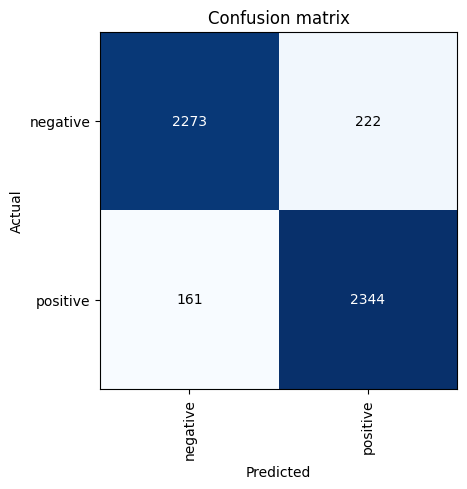

In [26]:
from fastai.interpret import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(clas_learner, ds_idx=1)
interp.y_true = tensor(df["sentiment"]=="positive")
interp.plot_confusion_matrix()

In [27]:
# Calculate accuracy (based on confusion matrix)
accuracy_value = np.diag(interp.confusion_matrix()).sum() / interp.confusion_matrix().sum()
print(f"Accuracy: {accuracy_value}")

Accuracy: 0.9234


In [30]:
# Calculate accuracy (based on prediction and targets)
preds, interp.y_true = clas_learner.get_preds(dl=data_clas.valid)
print(f"Accuracy: {accuracy(preds, interp.y_true)}")

Accuracy: TensorBase(0.9234)
